# 3.1. Generative adversarial network

## 3-1.1 Construct a DCGAN with GAN objective.

In [ ]:
import os
import cv2
import numpy as np
import random
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip -q /content/drive/MyDrive/DL2022_HW3/GAN_dataset.zip -d /content/MyColabDataset/

In [ ]:
### hyperparameter
NUM_EPOCH = 100
BATCH_SIZE = 128
IMAGE_SIZE = 64
NUM_CHANNEL = 3
Z_DIM = 100
LEARNING_RATE = 2e-4
BETA = 0.4
directory = '/content/MyColabDataset'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(), # numpy: (H,W,C) -> tensor: (C,H,W)
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # mean: (R, G, B), std: (R, G, B)
    ])

celebaData = datasets.ImageFolder(root=directory, transform=transform)   # (3, 218, 178)
data_loader = DataLoader(dataset=celebaData, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, n_channel, n_feature):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        nn.Conv2d(n_channel, n_feature, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2), 
        self.disc_block(n_feature, n_feature*2, 4, 2, 1),  # 16 * 16
        self.disc_block(n_feature*2, n_feature*4, 4, 2, 1),  # 8 * 8
        self.disc_block(n_feature*4, n_feature*8, 4, 2, 1),  # 4 * 4
        nn.Conv2d(n_feature*8, 1, kernel_size=4, stride=1, padding=0),  # 1 * 1
        nn.Sigmoid(),
    )

  def disc_block(self, in_channel, out_channel, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.LeakyReLU(0.2),
    )
    
  def forward(self, x):
    return self.disc(x)


class Generator(nn.Module):
  def __init__(self, z_dim, n_channel, n_feature):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        self.gen_block(z_dim, n_feature*8, 4, 1, 0),  # N * f*16 * 4 * 4
        self.gen_block(n_feature*8, n_feature*4, 4, 2, 1),  # 16 * 16
        self.gen_block(n_feature*4, n_feature*2, 4, 2, 1),  # 32 * 32
        self.gen_block(n_feature*2, n_feature, 4, 2, 1),  # 32 * 32
        nn.ConvTranspose2d(n_feature, n_channel, kernel_size=4, stride=2, padding=1),  # 64 * 64
        nn.Tanh(),  # [-1, 1]
    )

  def gen_block(self, in_channel, out_channel, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(),
    )
  
  def forward(self, x):
    return self.gen(x)


def weight_init(model):
  classname = model.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(model.weight.data, 1.0, 0.02)
    nn.init.constant_(model.bias.data, 0)


def plot_loss(loss_G, loss_D):
  plt.figure()
  plt.title('Loss')
  plt.plot(loss_G, label='G')
  plt.plot(loss_D, label='D')
  plt.xlabel('Iteration')
  plt.legend()
  plt.show()

In [ ]:
model_disc = Discriminator(NUM_CHANNEL, IMAGE_SIZE).to(device)
model_gen = Generator(Z_DIM, NUM_CHANNEL, IMAGE_SIZE).to(device)
criterion = nn.BCELoss()
optimizer_disc = optim.Adam(model_disc.parameters(), lr=LEARNING_RATE, betas=(BETA, 0.999))
optimizer_gen = optim.Adam(model_gen.parameters(), lr=LEARNING_RATE, betas=(BETA, 0.999))

fixed_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)

model_disc.apply(weight_init)
model_gen.apply(weight_init)

print('Discriminator: ', model_disc)
print('Generator: ', model_gen)

Discriminator:  Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (6): Sigmoid()
  )


In [ ]:
gen_lossList = []
disc_lossList = []
fixed_fakeList = []
iteration = 0

for epoch in range(NUM_EPOCH):
  for batch_idx, (real, _) in enumerate(data_loader):
    ### train Discriminator model: max log(D(x)) + log(1 - D(G(z)))
    model_disc.zero_grad()
    real = real.to(device)
    batch = real.size(0)
    disc_real = model_disc(real).view(-1)  # flatten
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
    loss_disc_real.backward()

    noise = torch.randn(batch, Z_DIM, 1, 1).to(device)
    fake = model_gen(noise)
    disc_fake = model_disc(fake.detach()).view(-1)
    loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    loss_disc_fake.backward()
    loss_disc = loss_disc_real + loss_disc_fake
    optimizer_disc.step()

    ### update Generator model: min log(1 - D(G(z))) --> max log(D(G(z)))
    model_gen.zero_grad()
    disc_gen_fake = model_disc(fake).view(-1)
    loss_gen = criterion(disc_gen_fake, torch.ones_like(disc_gen_fake))
    loss_gen.backward()
    optimizer_gen.step()

    gen_lossList.append(loss_gen.item())
    disc_lossList.append(loss_disc.item())

    if (batch_idx+1 % 100 == 0) or (batch_idx+1 == len(data_loader)):
      with torch.no_grad():
        fixed_fake = model_gen(fixed_noise).detach()
      fixed_fakeList.append(torchvision.utils.make_grid(fixed_fake, padding=2, normalize=True))

      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch+1, NUM_EPOCH, batch_idx+1, len(data_loader), loss_disc.item(), loss_gen.item()))

    iteration += 1

[1/100][79/79]	Loss_D: 2.2951	Loss_G: 10.5096
[2/100][79/79]	Loss_D: 0.6769	Loss_G: 7.2691
[3/100][79/79]	Loss_D: 1.0562	Loss_G: 5.4390
[4/100][79/79]	Loss_D: 0.7093	Loss_G: 5.8973
[5/100][79/79]	Loss_D: 0.5077	Loss_G: 4.9480
[6/100][79/79]	Loss_D: 0.6517	Loss_G: 5.5808
[7/100][79/79]	Loss_D: 1.5677	Loss_G: 6.8005
[8/100][79/79]	Loss_D: 0.5537	Loss_G: 3.9787
[9/100][79/79]	Loss_D: 0.8236	Loss_G: 4.2834
[10/100][79/79]	Loss_D: 1.0800	Loss_G: 6.3064
[11/100][79/79]	Loss_D: 1.8219	Loss_G: 1.7990
[12/100][79/79]	Loss_D: 1.1893	Loss_G: 6.8323
[13/100][79/79]	Loss_D: 0.6064	Loss_G: 2.9597
[14/100][79/79]	Loss_D: 0.5975	Loss_G: 2.5798
[15/100][79/79]	Loss_D: 0.9412	Loss_G: 4.6881
[16/100][79/79]	Loss_D: 1.0586	Loss_G: 7.0511
[17/100][79/79]	Loss_D: 0.7630	Loss_G: 4.8912
[18/100][79/79]	Loss_D: 0.5114	Loss_G: 3.0261
[19/100][79/79]	Loss_D: 0.6883	Loss_G: 6.6248
[20/100][79/79]	Loss_D: 0.6331	Loss_G: 2.3908
[21/100][79/79]	Loss_D: 0.7609	Loss_G: 2.4985
[22/100][79/79]	Loss_D: 0.8357	Loss_G: 5.8

### (a) Describe how you preprocess the dataset (such as resize, crop, rotate and flip) and explain why.

### (b) Plot the learning curves for both generator and discriminator.

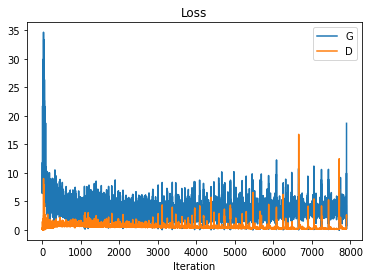

In [ ]:
plot_loss(gen_lossList, disc_lossList)

### (c) Draw some samples generated from your generator at different training stages. For example, you may show the results when running at $5^{th}$ and final learning iteration.

#### $5^{th}$ iteration

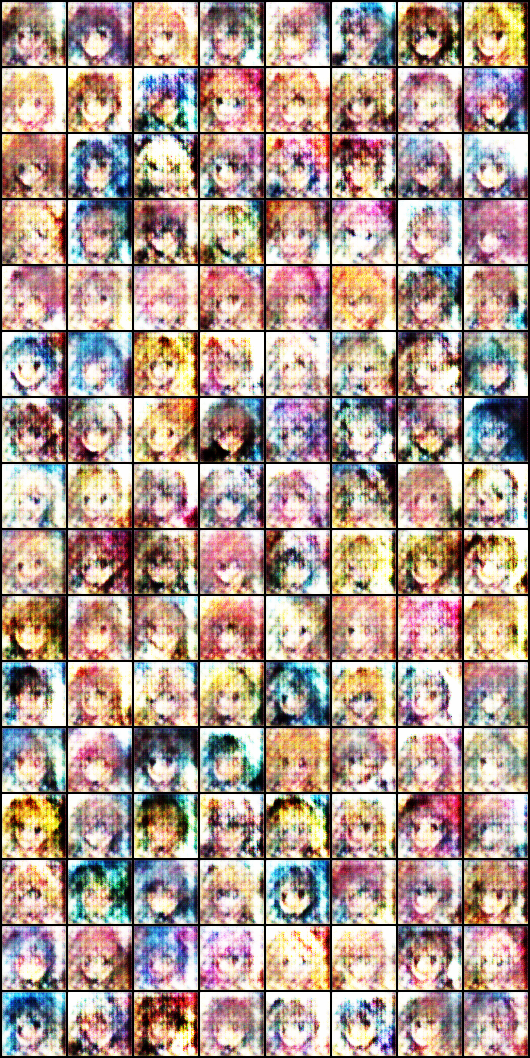

In [ ]:
cv2_imshow(cv2.cvtColor(fixed_fakeList[5].cpu().numpy().transpose(1, 2, 0)*255, cv2.COLOR_RGB2BGR))

#### Final iteration

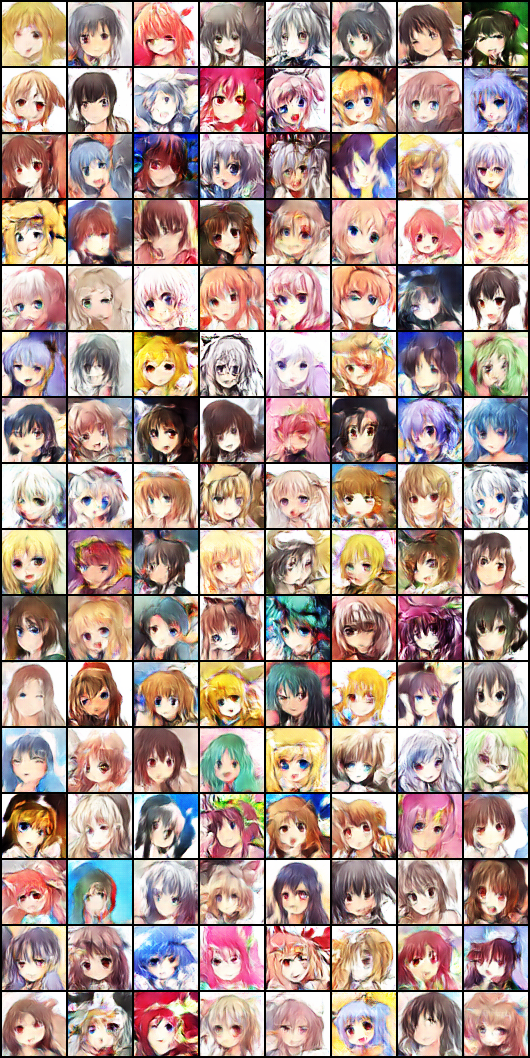

In [ ]:
cv2_imshow(cv2.cvtColor(fixed_fakeList[-1].cpu().numpy().transpose(1, 2, 0)*255, cv2.COLOR_RGB2BGR))

## 3-1.2. Please answer the following questions.

### (a) Please describe the meaning of the following four pictures during training of GAN, where blue dashed line indicates the discriminator, green solid line indicates the generator.

ANS: 
- black dashed line: data generating distribution $p_x$，真實資料的機率分布
- $x$: 真實資料
- $z$: 根據生成的機率分布（generative distribution）抽樣的資料
- 圖 b 為訓練 discriminator 的過程，使得模型最終收斂至 $D^*(x) = \frac{p_{data}(x)}{p_{data}(x)+p_g(x)}$（亦即 max $log(D(x)) + log(1 - D(G(z)))$）；而圖 c 為訓練 generator 的過程，使得生成機率分布越接近真實機率分布，最終收斂至 $p_g = p_{data}$（亦即 min $log(1 - D(G(z)))$）
- 當 $D(x) = \frac{1}{2}$ 時，換句話說，也就是 discriminator 的辨識能力等同於亂猜的期望值，且 generator 達到和真實機率分布相同的生成機率分布。

### (b) The Helvetica Scenario often happens during training procedure of GAN. Please explain why this problem occurs and how to avoid it.

ANS: Helvetica Scenario 表示不論輸入任何隨機抽樣的 $z$ 時，都會產出相同的生成結果 $x$，尤其是當 $G$ 在 $D$ 沒有更新的情況下訓練太多次。因此，必須在訓練的過程中保持 $D$ 與 $G$ 的同步。

### (c) Both VAE and GAN are generative models. The following figures are random generated results by using VAE (left) and GAN (right). Please compare two results and describe the pros and cons of two models.

ANS: VAE 的模型是透過 encoder 和 decoder 組成，其中 loss 為 reconstruction loss 和 latent loss 構成，前者確保 output 會與輸入的圖像相似，後者為確保 vector 會取固定範圍的值，兩個 loss 須做 trade-off，因此會使得產出的圖形較模糊；而 GAN 是由 discriminator 和 generator 相互對抗的模型，是一個 minmax game，理論上最終是要找出一個 equilibrium point，使得生成資料分布與真實資料分布相同（實務上很難找到這個點），最後訓練後產出的圖片會較 VAE 清晰。